In [1]:
from google.colab import drive
drive.mount("/content/drive")
drivePath="./drive/MyDrive/ACNEDETEC/"

MessageError: ignored

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os
import cv2
torch.nn.Module.dump_patches = True

In [ ]:
classes = array(['Normal','Acne'])
path =drivePath + 'dataset'
def get_y_fn(x):
   return Path(str(x.parent)+'annot')/x.name
Test_fnames= get_image_files(os.path.join(path +'/Test'))

Test_lbl_names= get_image_files(os.path.join(path+'/Testannot'))

Test_mask= open_mask(get_y_fn(Test_fnames[0]))
src_size= np.array(Test_mask.shape[1:])

In [ ]:
bs,size = 8,src_size

src= (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='Test')
       .label_from_func(get_y_fn, classes=classes)
      )


data= (src.transform(get_transforms(max_rotate = 2.0, max_warp = 0.1), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

name2id = {v:k for k,v in enumerate(classes)}

def accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
learn = unet_learner(data, models.resnet34, metrics=accuracy, wd=1e-2, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
from fastai.basic_train import load_learner
from fastai.vision.data import resize_to
from fastai.vision import *
from PIL import Image

learn=learn.load('model1_trained_5_19_2022')

In [ ]:
from fastai.train import lr_find
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


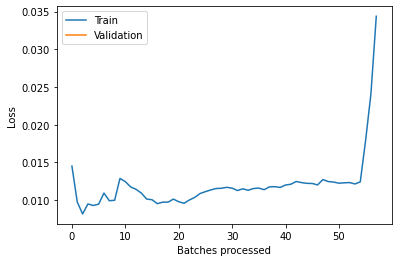

In [ ]:
learn.recorder.plot_losses()

tensor(0.0606)


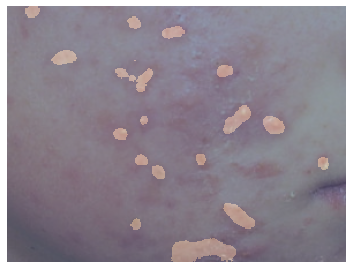

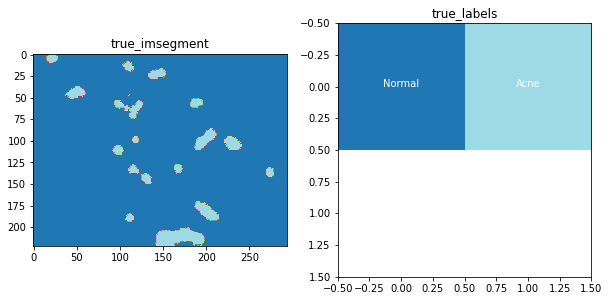

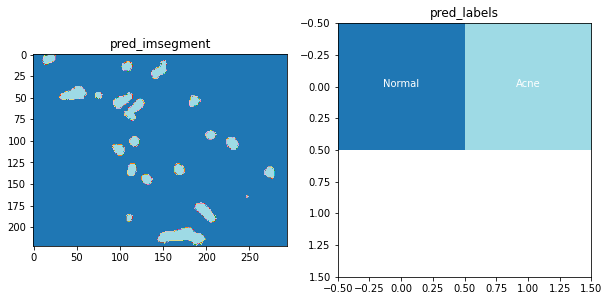

In [ ]:
from fastai.basic_data import DatasetType
from fastai.vision.interpret import SegmentationInterpretation
pred,y,loss=learn.get_preds(with_loss=True)
interp=SegmentationInterpretation.from_learner(learn)
top_losses, top_idxs=interp.top_losses((222,294))
top_losses, top_idxs
print(top_losses[1])
interp.show_xyz(top_idxs[1], classes, sz=10)

In [ ]:
interp=SegmentationInterpretation.from_learner(learn)
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
from fastai.vision.image import open_mask
from fastai.metrics import accuracy_thresh
from fastai.basic_train import load_learner
from fastai.vision.data import resize_to
from fastai.vision import *
from PIL import Image

learn=load_learner(drivePath+'dataset',file='export.pkl')

file = './drive/MyDrive/ACNEDETEC/test/levle2_89.jpg'
img = open_image(file)
img.resize(torch.Size([img.shape[0],256,256]))
print(img.shape)
pred= learn.predict(img)
a=accuracy_thresh(pred[1],pred[2])
img.show(figsize=(5,5))
img.show(figsize=(5,5) y=pred[0])
pred[0].show(figsize=(5,5))

#Android için model çıktısı

In [ ]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

final_model = nn.Sequential(learn.model,nn.Softmax()).to('cpu')

final_model.eval()
example = torch.rand(1, 3, 256, 256).cpu()

traced_script_module = torch.jit.trace(final_model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("./drive/MyDrive/ACNEDETEC/modelLite.ptl")